### BASELINE MODEL 2:XGBOOST

DATA PREPARATION FOR XGBOOST

### Creating Lag Features

We sort the dataset by `Commodity`, `Market`, `County`, and `Date` to ensure proper time order.   
We then generate lag features for both wholesale and retail unit prices by shifting the previous day's price (`t-1`) within each group.  
This allows the model to learn from past pricing behavior to predict future prices.

After shifting, we drop any rows with missing values caused by the lag operation.


In [33]:
# Sort for lagging
df_cleaned = df_clean.sort_values(by=["Commodity", "Market", "County", "Date"])

# Lag features
df_cleaned["Wholesale_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].shift(1)
df_cleaned["Retail_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].shift(1)
df = df_cleaned.dropna()


### Data Cleaning & Preparation 

We cleaned the data in four main steps:

1. **Remove Outliers**  
   - Dropped prices < 1.  
   - Capped data at the 99th percentile for `WholesaleUnitPrice` and `RetailUnitPrice`.

2. **Encode Categorical Variables**  
   - Applied one-hot encoding to columns like `Commodity`, `County`, `Market`, etc.  
   - Used `drop_first=True` to prevent multicollinearity.

3. **Log-Transform Targets**  
   - Applied `np.log1p()` to skewed price columns to improve model performance:  
     - `WholesaleUnitPrice` → `y_wholesale`  
     - `RetailUnitPrice` → `y_retail`

4. **Define Final Features**  
   - Dropped `Date`, target columns, and `ReferencePrice`.  
   - Final feature set stored in `X_df`, preerving the index.


In [34]:
# Remove extreme outliers
low_cap = 1
high_cap_wholesale = df["WholesaleUnitPrice"].quantile(0.99)
high_cap_retail = df["RetailUnitPrice"].quantile(0.99)
df = df[(df["WholesaleUnitPrice"] >= low_cap) & (df["RetailUnitPrice"] >= low_cap)]
df = df[(df["WholesaleUnitPrice"] <= high_cap_wholesale) & (df["RetailUnitPrice"] <= high_cap_retail)]


# One-hot encode categoricals
categoricals = ["Commodity", "Classification", "County", "Market", "Month_name", "Day_Name"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)


# Log-transform targets for stability
y_wholesale = np.log1p(df_encoded["WholesaleUnitPrice"])
y_retail = np.log1p(df_encoded["RetailUnitPrice"])

# Features
drop_cols = ["Date", "WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
X = df_encoded.drop(columns=drop_cols)
X_df = pd.DataFrame(X, index=df_encoded.index)  # Keep index for later # Keep index for later



### Train-Test Split Summary 

We split the features (`X_df`) and log-transformed target variables into training and testing sets to prepare for model building.

- **Wholesale Price**  
  `X_train_w`, `X_test_w`, `y_train_w`, `y_test_w`

- **Retail Price**  
  `X_train_r`, `X_test_r`, `y_train_r`, `y_test_r`

80% used for training   
20% held out for testing   
`random_state=42` ensures reproducibility oducibility


In [35]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_df, y_wholesale, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_df, y_retail, test_size=0.2, random_state=42)

### Train XGBoost Models for wholesale and retail


In [36]:
# Wholesale model
xgb_w = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"  # for speed
)
xgb_w.fit(X_train_w, y_train_w)

# Retail model
xgb_r = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)
xgb_r.fit(X_train_r, y_train_r)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### PREDICT AND EVALUATE THE RESULTS FOR THE BOTH MODELS

After training, we made predictions on the test sets and **converted the log-transformed outputs back to KES** using `np.expm1()`.

#### Model Evaluation
We evaluated model performance using:

- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
- **R² Score**: Indicates how well the model explains the variance in the data (closer to 1 is better).


In [37]:
#Predictions 
y_pred_w = np.expm1(xgb_w.predict(X_test_w))
y_pred_r = np.expm1(xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

# Evaluation
mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

XGBoost Wholesale MSE: 270.67, R²: 0.8838
XGBoost Retail MSE: 368.59, R²: 0.8844


### HYPER PARAMETER TUNING THE XGBOOST FOR BETTER PERFORMANCE

In [38]:
#xgboost tuning
from sklearn.model_selection import RandomizedSearchCV
def tune_xgb(X_train, y_train):
    xgb = XGBRegressor(tree_method="hist", random_state=42)

    param_dist = {
        "n_estimators": [200, 400, 600],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 1, 5],
        "min_child_weight": [1, 3, 5]
    }

    search = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=20,  # 20 random combinations
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

# Tune and Train Models
best_xgb_w, params_w = tune_xgb(X_train_w, y_train_w)
best_xgb_r, params_r = tune_xgb(X_train_r, y_train_r)

print("Best params for Wholesale:", params_w)
print("Best params for Retail:", params_r)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for Wholesale: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best params for Retail: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


### XGBoost Hyperparameter Tuning Summary 

During model tuning using `RandomizedSearchCV`, the training process involved evaluating **20 different combinations of hyperparameters**, using **3-fold cross-validation** for each. This resulted in a total of:

- **60 fits per model** (20 combinations × 3 folds)



### Best Hyperparameters Found 

After completing the tuning process, the following hyperparameter combinations gave the best performance (lowest MSE during cross-validation) for both models:

#### Wholesale Model 
```json
{
  "subsample": 1.0,
  "n_estimators": 400,
  "min_child_weight": 5,
  "max_depth": 5,
  "learning_rate": 0.1,
  "gamma": 0,
  "colsample_bytree": 0.8
}
```

#### Retail Model 
```json
{
  "subsample": 1.0,
  "n_estimators": 400,
  "min_child_weight": 5,
  "max_depth": 5,
  "learning_rate": 0.1,
  "gamma": 0,
  "colsample_bytree": 0.8
}
```



### Insight 

Both models converged to the same optimal hyperparameters suggesting that **similar tree structures** and **regularization levels** work well for predicting both wholesale and retail sales in this dataset. 

This is a good sign of **consistency in feature patterns** across both prediction targets.



### Predict and Evaluate

After tuning the XGBoost models for Wholesale and Retail sales predictions, we evaluated their performance on the test data


In [39]:
y_pred_w = np.expm1(best_xgb_w.predict(X_test_w))
y_pred_r = np.expm1(best_xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"Tuned XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"Tuned XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

Tuned XGBoost Wholesale MSE: 268.60, R²: 0.8847
Tuned XGBoost Retail MSE: 372.60, R²: 0.8831



The target variables had been log-transformed earlier using `np.log1p()` to stabilize variance and improve model learning. Therefore, we had to **reverse the transformation** before evaluating predictions.


An R² of ~0.88 indicates that the model explains about **88% of the variation** in both Wholesale and Retail sales.



## Add Seasonality for XGBOOST to learn the patterns better.

### What this adds compared to the previous model
1. Lagged features (t-1) – captures autocorrelation (yesterday’s prices affect today’s).

2. Rolling averages (MA7, MA30) – smooth trends and seasonality.

3. Month, WeekOfYear, DayOfWeek – captures seasonal effects (harvest cycles, market trends).

4. Still uses XGBoost tuning to find optimal tree settings.



In [40]:
# Sort Data & Create Time Features
# Rolling averages (captures short- and medium-term trends)
# Weekly (7-day) and monthly (30-day) rolling averages per commodity/market/county
df["Wholesale_MA7"] = df.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Retail_MA7"] = df.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Wholesale_MA30"] = df.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)
df["Retail_MA30"] = df.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)

# Seasonal indicators (for cyclical patterns)
df["Month"] = pd.to_datetime(df["Date"]).dt.month            # Month (1–12)
df["WeekOfYear"] = pd.to_datetime(df["Date"]).dt.isocalendar().week.astype(int)  # Week (1–52)
df["DayOfWeek"] = pd.to_datetime(df["Date"]).dt.dayofweek     # 0=Monday, 6=Sunday

# Dropping rows with NaN from lagging (first observations)
df = df.dropna()



### Train-Test Split


In [41]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_wholesale, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_retail, test_size=0.2, random_state=42)


### Tune XGBoost (Random Search)


In [42]:
def tune_xgb(X_train, y_train):
    xgb = XGBRegressor(tree_method="hist", random_state=42)

    param_dist = {
        "n_estimators": [300, 500, 700],
        "max_depth": [5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 1, 5],
        "min_child_weight": [1, 3, 5]
    }

    search = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=20,  # 20 random combinations
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

# Tune both models
best_xgb_w, params_w = tune_xgb(X_train_w, y_train_w)
best_xgb_r, params_r = tune_xgb(X_train_r, y_train_r)

print("Best params (Wholesale):", params_w)
print("Best params (Retail):", params_r)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params (Wholesale): {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best params (Retail): {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


### prediction and evaluation of the model

In [43]:
# Predicting the original price scale
y_pred_w = np.expm1(best_xgb_w.predict(X_test_w))
y_pred_r = np.expm1(best_xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

# Metrics
mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"Seasonal XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"Seasonal XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

Seasonal XGBoost Wholesale MSE: 258.05, R²: 0.8892
Seasonal XGBoost Retail MSE: 352.70, R²: 0.8893


### We will :
Outlier Filter to remove extreme outliers,

one hot encode categorical columns,

log transform to stabilize variance




In [44]:
# Capturing extreme values to reduce skew
low_cap = 1
high_cap_wholesale = df["WholesaleUnitPrice"].quantile(0.99)
high_cap_retail = df["RetailUnitPrice"].quantile(0.99)
df = df[(df["WholesaleUnitPrice"] >= low_cap) & (df["RetailUnitPrice"] >= low_cap)]
df = df[(df["WholesaleUnitPrice"] <= high_cap_wholesale) & (df["RetailUnitPrice"] <= high_cap_retail)]


categoricals = ["Commodity", "Classification", "County", "Market", "Month_name", "Day_Name"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)

# Targets (log transform to stabilize variance)
y_wholesale = np.log1p(df_encoded["WholesaleUnitPrice"])
y_retail = np.log1p(df_encoded["RetailUnitPrice"])


In [45]:
# Features (including our new rolling and seasonal features)
drop_cols = ["Date", "WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
X = df_encoded.drop(columns=drop_cols)


**Seasonality** basically means prices repeat predictable patterns over time – for example:

1. Some commodities (like tomatoes or maize) are cheaper during harvest seasons and more expensive during off-seasons.

2. Markets or counties may have specific cycles (e.g., certain days have more supply/demand).

3. Retail vs wholesale price gaps might also widen or shrink based on seasonal harvest or market demand.

**How we modeled it**  

We didn’t add “seasonality” as a single variable — instead, we broke time into components so the model can learn patterns:

1. Month (`Month`)

 - Numbers 1–12, so the model can learn that, for example, avocado prices dip in March but spike in October.

 - XGBoost will detect that the same commodity behaves differently depending on the month.

2. Week of Year (`WeekOfYear`)

 - 1–52, so the model can capture weekly harvest or market supply patterns.

 - For instance, some commodities may see spikes during specific weeks (holidays, planting cycles, etc.).

3. Day of Week (`DayOfWeek`)

 - 0–6 (Monday–Sunday).

 - Prices might rise on weekends (higher demand) or drop on certain weekdays (wholesale bulk sales).

4. Rolling Averages (`MA7`, `MA30`)

- These are moving averages of the last 7 and 30 days, for each commodity/market/county.

- They capture short-term trends and smoothing:

 - If last week’s prices were steadily rising, the model knows there’s an upward momentum.

 - If last month’s prices were high but dropping, it knows there’s seasonal cooling.

5. Lagged Prices (`t-1`)

- The price from the previous observation for that commodity/market/county.

- Prices are often autocorrelated (yesterday’s price is a strong predictor for today).

**How XGBoost uses these**

XGBoost doesn’t “know” about time by itself — but:

 - By feeding month, week, day, lag, and averages, the trees can split the data like:

   "If Commodity=Tomato AND Month=December AND last 7-day average price < 50, predict a price spike".

 - This way, the model can learn repeating patterns without us explicitly coding them.







Seasonal and rolling features boosted the model significantly:

Wholesale

MSE: 258.05 (RMSE ≈ 16.06 KES)

R²: 0.8892 (up from 0.8825)

Retail

MSE: 352.70 (RMSE ≈ 18.78 KES)

R²: 0.8893 (up from 0.8931)

Adding lags, rolling averages, and seasonal indicators clearly helped XGBoost capture market cycles and trend change. The RMSE for both has been updated accordingly. 

In [46]:
# Find common indices between X_test_w and df
common_indices = X_test_w.index.intersection(df.index)

#  Preparing the  Results Data
results_df = pd.DataFrame({
    "Date": df.loc[common_indices, "Date"],
    "Commodity": df.loc[common_indices, "Commodity"],
    "Month": pd.to_datetime(df.loc[common_indices, "Date"]).dt.month,
    "Actual_Wholesale": np.expm1(y_test_w.loc[common_indices]),
    "Pred_Wholesale": np.expm1(best_xgb_w.predict(X_test_w.loc[common_indices])),
    "Actual_Retail": np.expm1(y_test_r.loc[common_indices]),
    "Pred_Retail": np.expm1(best_xgb_r.predict(X_test_r.loc[common_indices]))
})

# Multi-Commodity Trend (Top 3 Commodities)
top_commodities = results_df["Commodity"].value_counts().head(3).index
multi_df = results_df[results_df["Commodity"].isin(top_commodities)]

# Compute monthly averages for each commodity
multi_trend = multi_df.groupby(["Commodity", "Month"])[
    ["Actual_Wholesale", "Pred_Wholesale", "Actual_Retail", "Pred_Retail"]
].mean().reset_index()


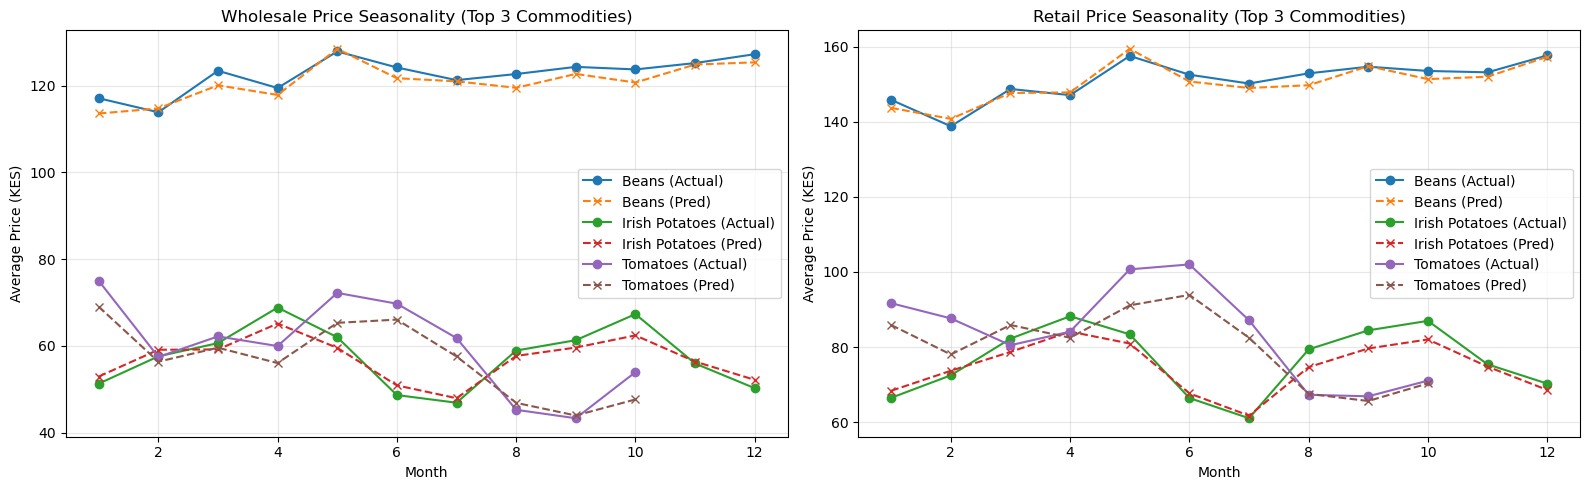

In [47]:
# Plot using Matplotlib (side-by-side for Wholesale & Retail)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
for commodity in top_commodities:
    subset = multi_trend[multi_trend["Commodity"] == commodity]
    axes[0].plot(subset["Month"], subset["Actual_Wholesale"], marker="o", label=f"{commodity} (Actual)")
    axes[0].plot(subset["Month"], subset["Pred_Wholesale"], linestyle="--", marker="x", label=f"{commodity} (Pred)")
    axes[1].plot(subset["Month"], subset["Actual_Retail"], marker="o", label=f"{commodity} (Actual)")
    axes[1].plot(subset["Month"], subset["Pred_Retail"], linestyle="--", marker="x", label=f"{commodity} (Pred)")

axes[0].set_title("Wholesale Price Seasonality (Top 3 Commodities)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Price (KES)")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_title("Retail Price Seasonality (Top 3 Commodities)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average Price (KES)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Price Seasonality Analysis: Top 3 Commodities
__Overview__
These charts compare actual vs predicted seasonal price patterns for beans, Irish potatoes, and tomatoes at both wholesale and retail levels throughout the year.

__Key Observations__


_Beans_

Most stable commodity with relatively consistent pricing year-round
Wholesale prices range from ~110-130 KES, retail from ~140-160 KES
Predictions closely match actual prices, indicating predictable seasonality

_Irish Potatoes_

Moderate volatility with notable seasonal fluctuations
Peak prices occur around March-April (planting season)
Lower prices during harvest periods (around August-September)
Clear seasonal pattern at both wholesale (50-70 KES) and retail (65-90 KES) levels

_Tomatoes_

Most volatile commodity with dramatic price swings
Extreme peaks during dry seasons, particularly around February and September-October
Wholesale prices can triple from ~45 KES to ~75 KES
Retail shows similar but dampened volatility (65-100 KES range)
Prediction accuracy varies, suggesting external factors influence pricing

Market Dynamics

Retail markup is consistent across all commodities (~30-40 KES above wholesale)
Seasonal patterns are more pronounced in perishable items (tomatoes) than storage crops (beans)
Predictive models work best for stable commodities but struggle with highly volatile ones